<a href="https://colab.research.google.com/github/AlgoAIBoss/CommonLit-Readability-Prize/blob/main/Bert_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold


import os
import random
import warnings
from tqdm import tqdm
warnings.simplefilter('ignore')

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import transformers

scaler = torch.cuda.amp.GradScaler()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
SEED = 508

def random_seed(SEED):
  random.seed(SEED)
  os.environ['PYTHONHASHSEED'] = str(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  torch.backends.cudnn.deterministic = True

random_seed(SEED)

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

{}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c commonlitreadabilityprize

401 - Unauthorized


In [ ]:
! unzip /content/train.csv.zip

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/KAGGLE/CommonLit Readability Prize/DATA/test.csv')
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/KAGGLE/CommonLit Readability Prize/DATA/train.csv')
sample = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/KAGGLE/CommonLit Readability Prize/DATA/sample_submission.csv')

# Preprocess

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
train = train.sort_values('target').reset_index(drop=True)

train['kfold'] = train.index % 5


trainset = train[train['kfold'] != 0].reset_index(drop=True)
validset = train[train['kfold'] == 0].reset_index(drop=True)

In [ ]:
class BERTDataSet(Dataset):
    def __init__(self, data, max_len, is_test=False):
        self.data = data
        self.sentences = self.data.excerpt.values.tolist()
        self.is_test = is_test
        self.max_len = max_len
        # if not self.is_test:
        #   self.targets = self.data.targets.values
        # else:
        #   pass


    
    def __len__(self):
        return len(self.data)
    


    def __getitem__(self, index):


# For Train Set
        if not self.is_test:

          sentence, label = self.sentences[index], self.data.target.values[index]
            
          bert_sens = tokenizer.encode_plus(
              sentence, 
              add_special_tokens = True,
              max_length = self.max_len,
              pad_to_max_length = True,
              return_attention_mask = True,
              truncation = True
              )


          ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
          mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
          token_type_ids = torch.tensor(bert_sens['token_type_ids'], dtype=torch.long)
          target = torch.tensor(label, dtype=torch.float)

          return {
              'ids':ids,
              'mask':mask,
              'token_type_ids':token_type_ids,
              'targets':target
          }



# For Test Set
        else:
          sentence = self.sentences[index]
          
          bert_sens = tokenizer.encode_plus(
              sentence, 
              add_special_tokens = True,
              max_length = self.max_len,
              pad_to_max_length = True,
              return_attention_mask = True,
              truncation = True
              )


          ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
          mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
          token_type_ids = torch.tensor(bert_sens['token_type_ids'], dtype=torch.long)

          return {
              'ids':ids,
              'mask':mask,
              'token_type_ids':token_type_ids,
          }

In [ ]:
train_dataset = BERTDataSet(trainset, 314, False)
valid_dataset = BERTDataSet(validset, 314, False)

In [ ]:
train_batch = 16
valid_batch = 32


train_dataloader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=4, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
def loss_fn(output, target):
  return torch.sqrt(nn.MSELoss()(output, target))

In [ ]:
from transformers import AdamW

LR = 2e-5

optimizer = AdamW(model.parameters(), LR, betas=(0.9, 0.999), weight_decay=1e-2)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 20

train_steps = int(len(trainset) / train_batch * epochs)

num_steps = int(train_steps * 0.1)

scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

In [ ]:
def training(train_dataloader, model, optimizer, scheduler):
  
  model.to(device)
  model.train()
  torch.backends.cudnn.benchmark = True

  allpreds = []
  alltargets = []


  for a in train_dataloader:

    losses = []

    optimizer.zero_grad()

    with torch.cuda.amp.autocast():

      ids = a['ids'].to(device, non_blocking=True)
      mask = a['mask'].to(device, non_blocking=True)
      tokentype = a['token_type_ids'].to(device, non_blocking=True)
      target = a['targets'].to(device, non_blocking=True)

      output = model(ids, mask)
      output = output.logits.squeeze(-1)

      loss = loss_fn(output, target)

      losses.append(loss.item())
      allpreds.append(output.detach().cpu().numpy())
      alltargets.append(target.detach().squeeze(-1).cpu().numpy())

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    scheduler.step()

  allpreds = np.concatenate(allpreds)
  alltargets = np.concatenate(alltargets)

  losses = np.mean(losses)

  train_rme_loss = np.sqrt(mean_squared_error(alltargets, allpreds))

  return losses, train_rme_loss

In [ ]:
def validating(valid_dataloader, model):

  model.to(device)
  model.eval()

  allpreds = []
  alltargets = []

  for a in valid_dataloader:

    losses = []

    with torch.no_grad():

      ids = a['ids'].to(device, non_blocking=True)
      mask = a['mask'].to(device, non_blocking=True)
      tokentype = a['token_type_ids'].to(device, non_blocking=True)
      target = a['targets'].to(device, non_blocking=True)

      output = model(ids, mask)
      output = output.logits.squeeze(-1)

      loss = loss_fn(output, target)

      losses.append(loss.item())
      allpreds.append(output.detach().cpu().numpy())
      alltargets.append(target.detach().squeeze(-1).cpu().numpy())


  allpreds = np.concatenate(allpreds)
  alltargets = np.concatenate(alltargets)

  losses = np.mean(losses)

  valid_rme_loss = np.sqrt(mean_squared_error(alltargets, allpreds))

  return allpreds, losses, valid_rme_loss

In [ ]:
trainlosses = []
vallosses = []
bestscore = None

trainscores = []
validscores = []

for epoch in tqdm(range(epochs)):
  print('------------------' + str(epoch) + 'start----------------')
  
  trainloss, trainscore = training(train_dataloader, model, optimizer, scheduler)

  trainlosses.append(trainloss)
  trainscores.append(trainscore)

  print('trainscore is ' + str(trainscore))

  

  preds, validloss, valscore = validating(valid_dataloader, model)

  vallosses.append(validloss)
  validscores.append(valscore)

  print('valscore is '+ str(valscore))




  if bestscore is None:

    bestscore = valscore

    print('Save first model')

    state = {
        'state_dict': model.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'bestscore':bestscore
    }

    torch.save(state, 'model0.pth')

  elif bestscore > valscore:

    bestscore = valscore 

    print('found better point')

    state = {
        'state_dict':model.state_dict(),
        'optimizer_dict':optimizer.state_dict(),
        'bestscore':bestscore
    }


  else:
    pass



  0%|          | 0/20 [00:00<?, ?it/s]

------------------0start----------------
trainscore is 0.36345086
valscore is 0.6182438
Save first model




  5%|▌         | 1/20 [01:17<24:37, 77.76s/it]

------------------1start----------------
trainscore is 0.35547408




 10%|█         | 2/20 [02:32<23:01, 76.75s/it]

valscore is 0.6666333
------------------2start----------------
trainscore is 0.33298987




 15%|█▌        | 3/20 [03:46<21:31, 76.00s/it]

valscore is 0.69976544
------------------3start----------------
trainscore is 0.27171072




 20%|██        | 4/20 [05:00<20:09, 75.58s/it]

valscore is 0.6182388
found better point
------------------4start----------------
trainscore is 0.25163114




 25%|██▌       | 5/20 [06:15<18:49, 75.29s/it]

valscore is 0.6670613
------------------5start----------------
trainscore is 0.22167198




 30%|███       | 6/20 [07:29<17:29, 74.98s/it]

valscore is 0.6173804
found better point
------------------6start----------------
trainscore is 0.20581566




 35%|███▌      | 7/20 [08:44<16:11, 74.76s/it]

valscore is 0.69083655
------------------7start----------------
trainscore is 0.18514587




 40%|████      | 8/20 [09:58<14:56, 74.67s/it]

valscore is 0.6884422
------------------8start----------------
trainscore is 0.17145747




 45%|████▌     | 9/20 [11:13<13:40, 74.61s/it]

valscore is 0.6408061
------------------9start----------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f24f845b9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f24f845b9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

trainscore is 0.16236189




 50%|█████     | 10/20 [13:08<14:28, 86.89s/it]

valscore is 0.6019752
found better point
------------------10start----------------
trainscore is 0.14435098




 55%|█████▌    | 11/20 [14:22<12:27, 83.04s/it]

valscore is 0.6341251
------------------11start----------------
trainscore is 0.13675222




 60%|██████    | 12/20 [15:36<10:43, 80.40s/it]

valscore is 0.62684375
------------------12start----------------
trainscore is 0.13389252




 65%|██████▌   | 13/20 [16:51<09:09, 78.53s/it]

valscore is 0.6319059
------------------13start----------------
trainscore is 0.1325708




 70%|███████   | 14/20 [18:05<07:43, 77.30s/it]

valscore is 0.57362163
found better point
------------------14start----------------
trainscore is 0.11924451




 75%|███████▌  | 15/20 [19:19<06:22, 76.45s/it]

valscore is 0.5943799
------------------15start----------------
trainscore is 0.11490031




 80%|████████  | 16/20 [20:34<05:03, 75.81s/it]

valscore is 0.60127294
------------------16start----------------
trainscore is 0.108689025




 85%|████████▌ | 17/20 [21:48<03:46, 75.39s/it]

valscore is 0.61802256
------------------17start----------------
trainscore is 0.10399678




 90%|█████████ | 18/20 [23:03<02:30, 75.15s/it]

valscore is 0.6114876
------------------18start----------------
trainscore is 0.09702081




 95%|█████████▌| 19/20 [24:17<01:14, 74.85s/it]

valscore is 0.5981423
------------------19start----------------
trainscore is 0.097133115




100%|██████████| 20/20 [25:31<00:00, 76.58s/it]

valscore is 0.6079452


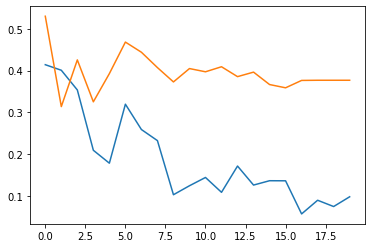

In [ ]:
x = np.arange(epochs)
plt.plot(x, trainlosses, label='train')
plt.plot(x, vallosses, label='valid')
plt.show()

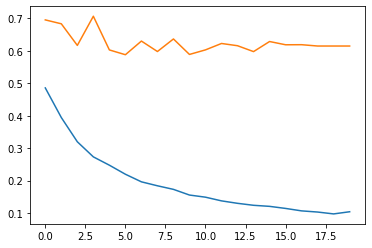

In [ ]:
x = np.arange(epochs)
plt.plot(x, trainscores)
plt.plot(x, validscores)
plt.show()

# Prediction

In [ ]:
import gc

del train_dataset, valid_dataset, train_dataloader, valid_dataloader, model, optimizer, scheduler, scaler

_ = gc.collect()

In [ ]:
test_dataset = BERTDataSet(test, 314, True)

In [ ]:
test_batch = 32

test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=4, pin_memory=True)
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
pthes = [os.path.join('./', s) for s in os.listdir('./') if '.pth' in s]
pthes

['./model0.pth']

In [ ]:
def predicting(test_dataloader, model, pthes):
  allpreds = []

  for pth in pthes:

    state = torch.load(pth)

    model.load_state_dict(state['state_dict'])
    model.to(device)
    model.eval()

    preds = []
    allvalloss = 0

    with torch.no_grad():

      for a in test_dataloader:

        ids = a['ids'].to(device)
        mask = a['mask'].to(device)
        tokentype = a['token_type_ids'].to(device)

        output = model(ids, mask)

        output = output.logits.squeeze(-1)

        preds.append(output.cpu().numpy())

      preds = np.concatenate(preds)

      allpreds.append(preds)

  return allpreds

In [ ]:
allpreds = predicting(test_dataloader, model, pthes)

In [ ]:
predictions = pd.DataFrame(allpreds).mean(axis=1)

In [ ]:
sample['target'] = predictions

In [ ]:
sample.to_csv('submission.csv', index=False)